# I want to analyse sales of lands with respect to different variables

In [1]:
import pandas as pd
import numpy as np
import missingno as mano
from sklearn.impute import KNNImputer

In [2]:
#import the data
salesdf = pd.read_csv("nyc-rolling-sales-dirty.csv")

C:\Users\Omer Abid\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Taking a look at the data
salesdf.head(5)

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392.0,No Number,,65000,NaN,...,5,0,5,1633,6440,1900,2,C2,6625000,why
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399.0,26,,C7,NaN,...,28,3,31,4616,18690,1900,2,C7,-,12/14/2016 0:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,NaN,399.0,39,,C7,NaN,...,16,1,17,2212,7803,1900,2,C7,-,12/9/2016 0:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,NaN,402.0,21,,C4,NaN,...,10,0,10,2272,6794,1913,2,C4,3936272,9/23/2016 0:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,NaN,404.0,55,,C2,NaN,...,6,0,6,2369,4615,1900,2,C2,8000000,11/17/2016 0:00


In [4]:
#viewing data types
salesdf.dtypes

Unnamed: 0                          int64
BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING CLASS CATEGORY            object
TAX CLASS AT PRESENT               object
BLOCK                             float64
LOT                                object
EASE-MENT                          object
BUILDING CLASS AT PRESENT          object
ADDRESS                            object
APARTMENT NUMBER                   object
ZIP CODE                          float64
RESIDENTIAL UNITS                   int64
COMMERCIAL UNITS                    int64
TOTAL UNITS                         int64
LAND SQUARE FEET                   object
GROSS SQUARE FEET                  object
YEAR BUILT                          int64
TAX CLASS AT TIME OF SALE           int64
BUILDING CLASS AT TIME OF SALE     object
SALE PRICE                         object
SALE DATE                          object
dtype: object

In [5]:
#seeing the null values for each columns
salesdf.isnull().sum()

Unnamed: 0                         0
BOROUGH                            0
NEIGHBORHOOD                      30
BUILDING CLASS CATEGORY           51
TAX CLASS AT PRESENT               7
BLOCK                             16
LOT                                0
EASE-MENT                          0
BUILDING CLASS AT PRESENT          0
ADDRESS                           45
APARTMENT NUMBER                   1
ZIP CODE                          36
RESIDENTIAL UNITS                  0
COMMERCIAL UNITS                   0
TOTAL UNITS                        0
LAND SQUARE FEET                   0
GROSS SQUARE FEET                  0
YEAR BUILT                         0
TAX CLASS AT TIME OF SALE          0
BUILDING CLASS AT TIME OF SALE     0
SALE PRICE                         0
SALE DATE                          0
dtype: int64

In [6]:
#unnamed: 0 makes no sense and we don't find any description of it from the website as well so we should drop it
salesdf = salesdf.drop('Unnamed: 0',axis=1)
#similarly while i viewed the csv manually just to get an overlook, i found most of the values in column APARTMENT NUMBER 
#are none but due to format issue there are not recognized as null in pd dataframe. So we should drop this column as well
salesdf = salesdf.drop('APARTMENT NUMBER',axis=1)
#similarly Ease-ment column is all empty but due to format issues they are not recognized as null
salesdf= salesdf.drop('EASE-MENT',axis=1)
#ADDRESS column almost has unique values so it would not provide us with any good dimentional query so its better to drop it
salesdf= salesdf.drop('ADDRESS',axis=1)

In [7]:
#current columns left in the dataset
salesdf.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'BUILDING CLASS AT PRESENT',
       'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')

In [8]:
#so i figured out from the glossary of borough that Tax class at present column can have values from 1 to 4, but we
#see that in the data we have value like 2A, 2C. so what i have done is that i have removed the alphabet part and save the
#number in place because it seems that in data mistakenly alphabets have been added to valid number. because a number is
#never seen to be out of range even if it appears with an alphabet in the dataframe. Also they are many recognized null cells
#as well in data
salesdf['TAX CLASS AT PRESENT'].value_counts()

1     38633
2     30915
4      6140
2A     2520
2C     1915
1A     1444
1B     1234
2B      812
        738
1C      186
3         4
Name: TAX CLASS AT PRESENT, dtype: int64

In [9]:
salesdf['TAX CLASS AT PRESENT'] = salesdf['TAX CLASS AT PRESENT'].astype(str)
import re
def formatval(item):
    if re.match(r"[1-4]\D$", item):
        return item[0] 
    elif re.match(r"[1-4]$", item):
        return item
    else:
        return None
    
    
salesdf['TAX CLASS AT PRESENT'] = salesdf['TAX CLASS AT PRESENT'].map(formatval)    

In [10]:
#similarly i found string item in the LOT column whereas it can only contain numbers, so a mechnism to replace string to NaN
#is implemented
salesdf['LOT'] = salesdf['LOT'].astype(str)  
import re
def strtonan(item):
    if re.match(r"[0-9]+$", item):
        return item 
    else:
        return None
    
salesdf['LOT'] = salesdf['LOT'].map(strtonan)    

In [11]:
#similary this is an alphanumeric column but i found an instance of a integer in to so have replace them np.nan
salesdf['BUILDING CLASS AT PRESENT'] = salesdf['BUILDING CLASS AT PRESENT'].astype(str)  
import re
def numtonan(item):
    if item.isdigit()==False:
        return item
    else:
        return None
salesdf['BUILDING CLASS AT PRESENT'] = salesdf['BUILDING CLASS AT PRESENT'].map(numtonan) 

In [12]:
#Next 'land square feet','gross square feet' and SALE PRICE  have '-' to show empty data but for us its misleading because 
#we cannot recognize nulls so have to change them to np.nan
salesdf['LAND SQUARE FEET'] = salesdf['LAND SQUARE FEET'].astype(str)
salesdf['GROSS SQUARE FEET'] = salesdf['GROSS SQUARE FEET'].astype(str)
salesdf['SALE PRICE']=salesdf['SALE PRICE'].astype(str)
import re
def tonan(item):
    if item.isdigit():
        return item
    else:
        return None
            
salesdf['LAND SQUARE FEET'] = salesdf['LAND SQUARE FEET'].map(tonan)       
salesdf['GROSS SQUARE FEET'] = salesdf['GROSS SQUARE FEET'].map(tonan)
salesdf['SALE PRICE']=salesdf['SALE PRICE'].map(tonan)

In [13]:
#next we see that many year built rows have value '0' which cannot be possible in reality so we should replace with np.nan
#aswell
salesdf['YEAR BUILT'].value_counts()

0       6970
1920    6045
1930    5043
1925    4312
1910    3585
        ... 
1832       1
1849       1
1829       1
1111       1
1888       1
Name: YEAR BUILT, Length: 158, dtype: int64

In [14]:
#Along with year built zip code and total units also had 0s which should be replaced by np.nan because they are invalid and 
#0 values cannot exits in these columns logically according to business knowledge
salesdf['YEAR BUILT'] = salesdf['YEAR BUILT'].astype(int)
salesdf['ZIP CODE'] = salesdf['ZIP CODE'].astype(float)
salesdf['TOTAL UNITS']=salesdf['TOTAL UNITS'].astype(int)
import re
def zerotonull(item):
    if item!=0:
        return item
    else:
        return None
salesdf['YEAR BUILT'] = salesdf['YEAR BUILT'].map(zerotonull)
salesdf['ZIP CODE'] = salesdf['ZIP CODE'].map(zerotonull)
salesdf['TOTAL UNITS']=salesdf['TOTAL UNITS'].map(zerotonull)

In [15]:
#lastly we see that sales date column as strings in it we need to replace it with np.nan
salesdf['SALE DATE'] = salesdf['SALE DATE'].astype(str)  
import re
def dateinco(item):
    if re.match(r"\D*$", item):
        return None
    else:
        return item
salesdf['SALE DATE'] = salesdf['SALE DATE'].map(dateinco) 

In [16]:
#since Total unit is addition of residential and commercial unit, when total unit is null these two values should also be
#null.
salesdf['RESIDENTIAL UNITS'] = np.where(salesdf['TOTAL UNITS'].isnull(), np.nan, salesdf['RESIDENTIAL UNITS'])
salesdf['COMMERCIAL UNITS'] = np.where(salesdf['TOTAL UNITS'].isnull(), np.nan, salesdf['COMMERCIAL UNITS']) 

In [17]:
#here i am changing the data types for some column and in order to change the data types for integer/float columns i need to
#mask the nulls for the time being 
salesdf['RESIDENTIAL UNITS']=salesdf['RESIDENTIAL UNITS'].fillna(-1000)
salesdf['COMMERCIAL UNITS'] = salesdf['COMMERCIAL UNITS'].fillna(-1000)
salesdf['LAND SQUARE FEET'] = salesdf['LAND SQUARE FEET'].fillna(-1000)
salesdf['GROSS SQUARE FEET'] = salesdf['GROSS SQUARE FEET'].fillna(-1000)
salesdf['SALE PRICE'] = salesdf['SALE PRICE'].fillna(-1000)
salesdf['YEAR BUILT'] = salesdf['YEAR BUILT'].fillna(-1000)

salesdf['BOROUGH'] = salesdf['BOROUGH'].astype(str,skipna=True)
salesdf['NEIGHBORHOOD'] = salesdf['NEIGHBORHOOD'].astype(str,skipna=True)
salesdf['BUILDING CLASS CATEGORY'] = salesdf['BUILDING CLASS CATEGORY'].astype(str,skipna=True)
salesdf['TAX CLASS AT PRESENT'] = salesdf['TAX CLASS AT PRESENT'].astype(str,skipna=True)
salesdf['BLOCK'] = salesdf['BLOCK'].astype(str,skipna=True)
salesdf['LOT'] = salesdf['LOT'].astype(str,skipna=True)
salesdf['BUILDING CLASS AT PRESENT'] = salesdf['BUILDING CLASS AT PRESENT'].astype(str,skipna=True)
salesdf['ZIP CODE'] = salesdf['ZIP CODE'].astype(str,skipna=True)
salesdf['RESIDENTIAL UNITS'] = salesdf['RESIDENTIAL UNITS'].astype(int)
salesdf['COMMERCIAL UNITS'] = salesdf['COMMERCIAL UNITS'].astype(int)
salesdf['TOTAL UNITS'] = salesdf['TOTAL UNITS'].astype(str,skipna=True)
salesdf['LAND SQUARE FEET'] = salesdf['LAND SQUARE FEET'].astype(float)
salesdf['GROSS SQUARE FEET'] = salesdf['GROSS SQUARE FEET'].astype(float)
salesdf['YEAR BUILT'] = salesdf['YEAR BUILT'].astype(str)
salesdf['TAX CLASS AT TIME OF SALE'] = salesdf['TAX CLASS AT TIME OF SALE'].astype(str,skipna=True)
salesdf['BUILDING CLASS AT TIME OF SALE'] = salesdf['BUILDING CLASS AT TIME OF SALE'].astype(str,skipna=True)
salesdf['SALE PRICE'] = salesdf['SALE PRICE'].astype(float)
salesdf['SALE DATE'] = salesdf['SALE DATE'].astype(str,skipna=True)
#here i am replacing the masked nulls to np.nan
salesdf=salesdf.replace(-1000, np.nan)


In [18]:
#just getting a look at the data
salesdf

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,392.0,None,None,10009.0,5.0,0.0,5.0,1633.0,6440.0,1900.0,2,C2,6625000.0,None
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399.0,26,C7,NaN,28.0,3.0,31.0,4616.0,18690.0,1900.0,2,C7,NaN,12/14/2016 0:00
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,None,399.0,39,C7,NaN,16.0,1.0,17.0,2212.0,7803.0,1900.0,2,C7,NaN,12/9/2016 0:00
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,None,402.0,21,C4,NaN,10.0,0.0,10.0,2272.0,6794.0,1913.0,2,C4,3936272.0,9/23/2016 0:00
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,None,404.0,55,C2,NaN,6.0,0.0,6.0,2369.0,4615.0,1900.0,2,C2,8000000.0,11/17/2016 0:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349.0,34,B9,10309.0,2.0,0.0,2.0,2400.0,2575.0,1998.0,1,B9,450000.0,11/28/2016 0:00
84544,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349.0,78,B9,10309.0,2.0,0.0,2.0,2498.0,2377.0,1998.0,1,B9,550000.0,4/21/2017 0:00
84545,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7351.0,60,B2,10309.0,2.0,0.0,2.0,4000.0,1496.0,1925.0,1,B2,460000.0,7/5/2017 0:00
84546,5,WOODROW,22 STORE BUILDINGS,4,7100.0,28,K6,10309.0,0.0,7.0,7.0,208033.0,64117.0,2001.0,4,K6,11693337.0,12/21/2016 0:00


In [19]:
#Now we see the real amount of nulls in our data which we need to handle
salesdf.isnull().sum()

BOROUGH                               0
NEIGHBORHOOD                         30
BUILDING CLASS CATEGORY              51
TAX CLASS AT PRESENT                745
BLOCK                                16
LOT                                  10
BUILDING CLASS AT PRESENT             1
ZIP CODE                           1018
RESIDENTIAL UNITS                 19762
COMMERCIAL UNITS                  19762
TOTAL UNITS                       19762
LAND SQUARE FEET                  26252
GROSS SQUARE FEET                 27612
YEAR BUILT                            0
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                        14561
SALE DATE                             3
dtype: int64

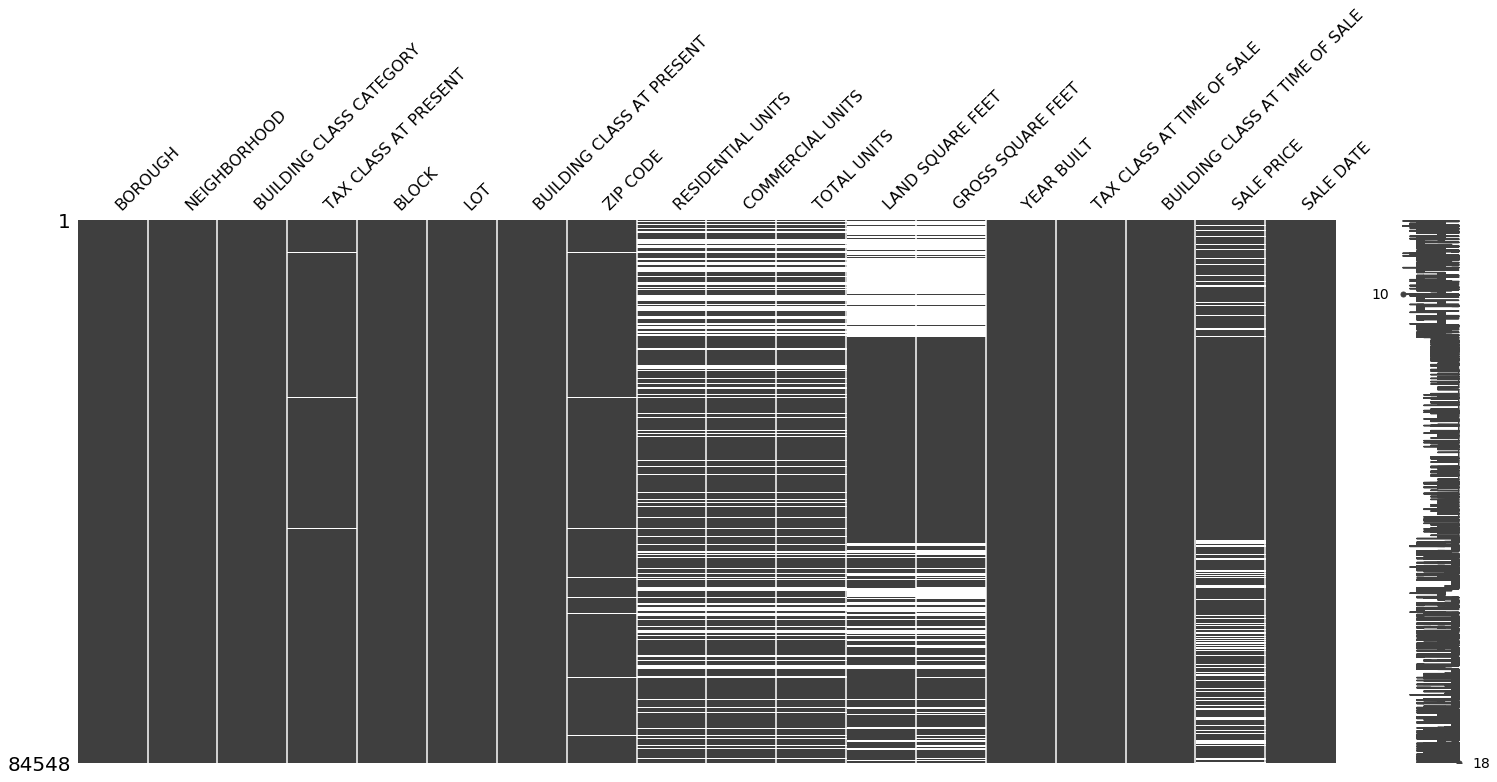

In [20]:
#mano matrix helps us visualize occurence of nulls 
mano.matrix(salesdf)

In [21]:
#for LAND SQUARE FEET and GROSS SQUARE FEET we see they have very similar missing value pattern

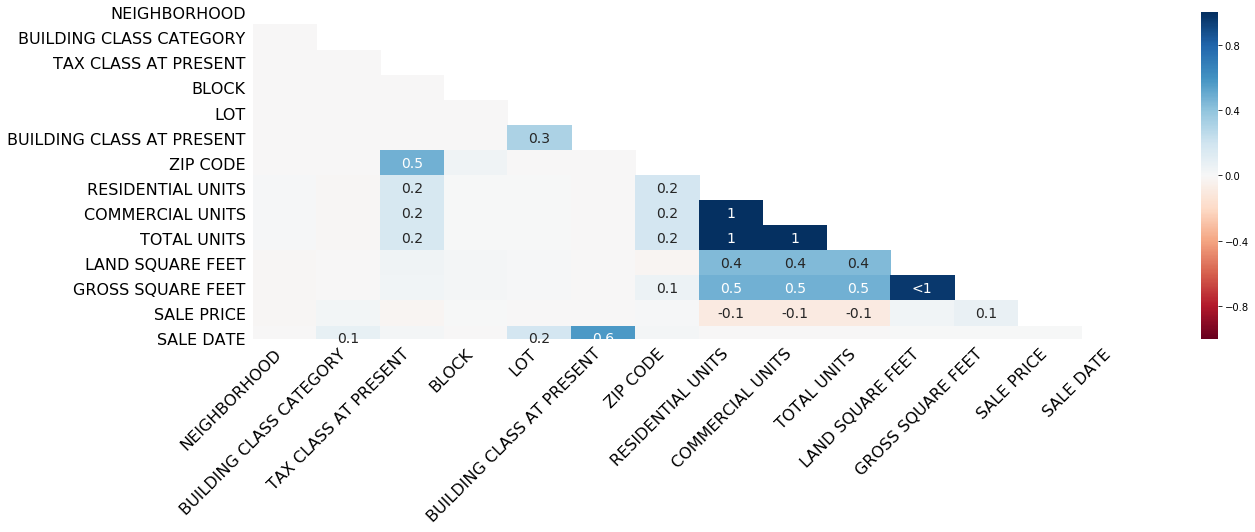

In [22]:
mano.heatmap(salesdf, figsize=(20,6))

In [23]:
#starting with the missing values of NEIGHBORHOOD column its values come in series of same values so its best
#to fill a missing values by its surrounding values for this column
#all of the columns listed after NEIGHBOURHOOD below also have the same case so we use the same strategy.
salesdf['NEIGHBORHOOD']=salesdf['NEIGHBORHOOD'].fillna(axis=0,method='ffill') 
salesdf['BUILDING CLASS CATEGORY']=salesdf['BUILDING CLASS CATEGORY'].fillna(axis=0,method='ffill')
salesdf['ZIP CODE']=salesdf['ZIP CODE'].fillna(axis=0,method='ffill')
salesdf['YEAR BUILT']=salesdf['YEAR BUILT'].fillna(axis=0,method='ffill')
salesdf['SALE DATE']=salesdf['SALE DATE'].fillna(axis=0,method='bfill')
salesdf['LOT']=salesdf['LOT'].fillna(axis=0,method='bfill')
salesdf['BUILDING CLASS AT PRESENT']=salesdf['BUILDING CLASS AT PRESENT'].fillna(axis=0,method='bfill')

In [24]:
#Logically thinking in terms of business knowledge, for the TAX CLASS AT PRESENT column i suppect it is highly correlated 
#to the TAX CLASS AT TIME OF SALE column so i fill it using the TAX CLASS AT TIME OF SALE column for the same row
salesdf['TAX CLASS AT PRESENT']=salesdf['TAX CLASS AT PRESENT'].fillna(salesdf['TAX CLASS AT TIME OF SALE'])

In [25]:
#for each colums we have two boxplots below, one is before filling missing values and one is after, i am making sure the
#strategy i use does not disturb the histograms meaning the distribuition remains same.

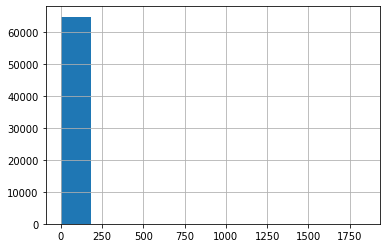

In [26]:
salesdf['RESIDENTIAL UNITS'].hist()

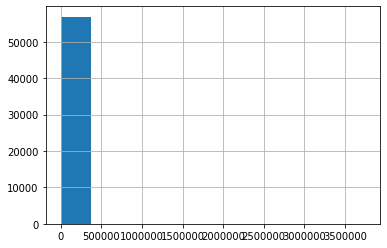

In [27]:
salesdf['GROSS SQUARE FEET'].hist()

In [28]:
imputer = KNNImputer (n_neighbors=2)
salesdf[['BLOCK','RESIDENTIAL UNITS','GROSS SQUARE FEET']] = imputer.fit_transform(salesdf[['BLOCK','RESIDENTIAL UNITS','GROSS SQUARE FEET']])

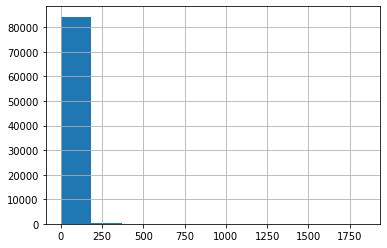

In [29]:
salesdf['RESIDENTIAL UNITS'].hist()

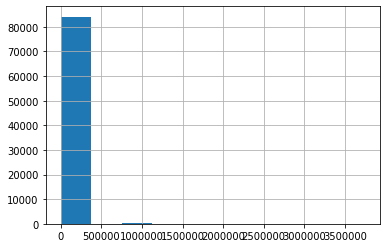

In [30]:
salesdf['GROSS SQUARE FEET'].hist()

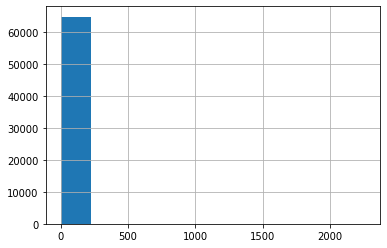

In [31]:
salesdf['COMMERCIAL UNITS'].hist()

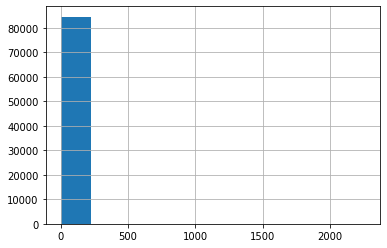

In [32]:
salesdf['COMMERCIAL UNITS']=salesdf['COMMERCIAL UNITS'].interpolate(method ='ffill', limit_direction ='backward')
salesdf['COMMERCIAL UNITS'].hist()

In [33]:
#since we have filled up the missing values in commerical unit column and residencial units column we now add them to form 
#the total unit column
salesdf['TOTAL UNITS']=salesdf['COMMERCIAL UNITS']+salesdf['RESIDENTIAL UNITS']

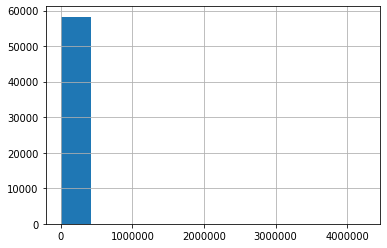

In [34]:
salesdf['LAND SQUARE FEET'].hist()

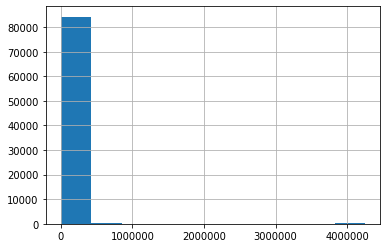

In [35]:
salesdf['LAND SQUARE FEET'] = salesdf['LAND SQUARE FEET'].interpolate(method ='ffill', limit_direction ='backward')
salesdf['LAND SQUARE FEET'].hist()

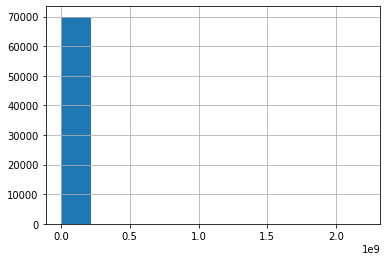

In [36]:
salesdf['SALE PRICE'].hist()

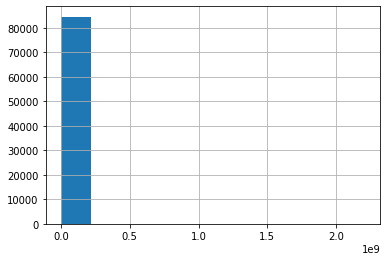

In [37]:
salesdf['SALE PRICE'] = salesdf['SALE PRICE'].interpolate(method ='ffill', limit_direction ='backward')
salesdf['SALE PRICE'].hist()

In [38]:
#all the nulls have been handled now
salesdf.isnull().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING CLASS CATEGORY           0
TAX CLASS AT PRESENT              0
BLOCK                             0
LOT                               0
BUILDING CLASS AT PRESENT         0
ZIP CODE                          0
RESIDENTIAL UNITS                 0
COMMERCIAL UNITS                  0
TOTAL UNITS                       0
LAND SQUARE FEET                  0
GROSS SQUARE FEET                 0
YEAR BUILT                        0
TAX CLASS AT TIME OF SALE         0
BUILDING CLASS AT TIME OF SALE    0
SALE PRICE                        0
SALE DATE                         0
dtype: int64

In [39]:
#lets just covert the sales date column to datetime type
salesdf['SALE DATE'] = pd.to_datetime(salesdf['SALE DATE'])
#now we check the datatype
salesdf.dtypes

BOROUGH                                   object
NEIGHBORHOOD                              object
BUILDING CLASS CATEGORY                   object
TAX CLASS AT PRESENT                      object
BLOCK                                    float64
LOT                                       object
BUILDING CLASS AT PRESENT                 object
ZIP CODE                                  object
RESIDENTIAL UNITS                        float64
COMMERCIAL UNITS                         float64
TOTAL UNITS                              float64
LAND SQUARE FEET                         float64
GROSS SQUARE FEET                        float64
YEAR BUILT                                object
TAX CLASS AT TIME OF SALE                 object
BUILDING CLASS AT TIME OF SALE            object
SALE PRICE                               float64
SALE DATE                         datetime64[ns]
dtype: object

In [40]:
#just fixing some data types
salesdf['BLOCK'] = salesdf['BLOCK'].astype(str,skipna=True)
salesdf['LAND SQUARE FEET'] = salesdf['LAND SQUARE FEET'].astype(int)
salesdf['GROSS SQUARE FEET'] = salesdf['GROSS SQUARE FEET'].astype(int)
salesdf['RESIDENTIAL UNITS'] = salesdf['RESIDENTIAL UNITS'].astype(int)
salesdf['COMMERCIAL UNITS'] = salesdf['COMMERCIAL UNITS'].astype(int)
salesdf['TOTAL UNITS'] = salesdf['TOTAL UNITS'].astype(int)

In [41]:
#now we check the datatype for final time
salesdf.dtypes

BOROUGH                                   object
NEIGHBORHOOD                              object
BUILDING CLASS CATEGORY                   object
TAX CLASS AT PRESENT                      object
BLOCK                                     object
LOT                                       object
BUILDING CLASS AT PRESENT                 object
ZIP CODE                                  object
RESIDENTIAL UNITS                          int32
COMMERCIAL UNITS                           int32
TOTAL UNITS                                int32
LAND SQUARE FEET                           int32
GROSS SQUARE FEET                          int32
YEAR BUILT                                object
TAX CLASS AT TIME OF SALE                 object
BUILDING CLASS AT TIME OF SALE            object
SALE PRICE                               float64
SALE DATE                         datetime64[ns]
dtype: object

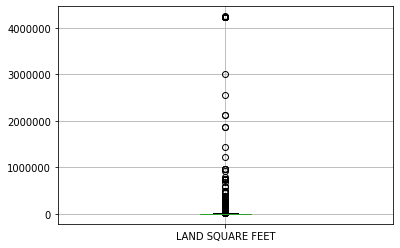

In [42]:
#now lets make box plots for each of the numeric columns to check for outliers
salesdf.boxplot(column='LAND SQUARE FEET', sym='o', return_type='axes')

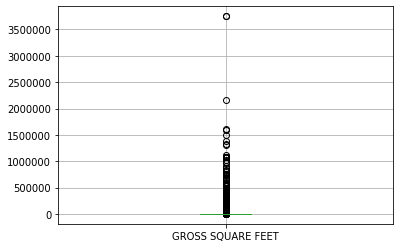

In [43]:
salesdf.boxplot(column='GROSS SQUARE FEET', sym='o', return_type='axes')

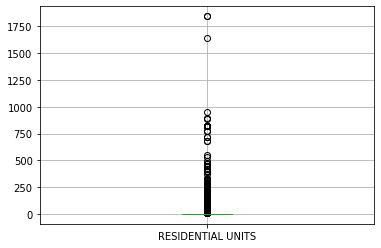

In [44]:
salesdf.boxplot(column='RESIDENTIAL UNITS', sym='o', return_type='axes')

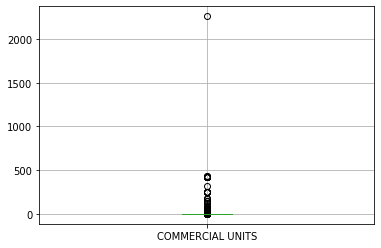

In [45]:
salesdf.boxplot(column='COMMERCIAL UNITS', sym='o', return_type='axes')

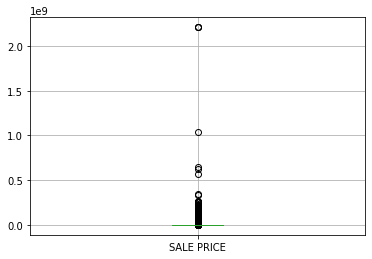

In [46]:
salesdf.boxplot(column='SALE PRICE', sym='o', return_type='axes')

In [47]:
#so from all the box plots above only the points which are at the very top and few can be considered as outliers,
#When the line becomes uniform black in the boxplot we need to adjust our data set selection for these column so that we
#get an optimal boxplot with maximum data selected from each column

In [48]:
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from scipy.stats import chi2_contingency
from scipy.stats import chi2

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.gofplots import qqplot
from scipy import stats

In [49]:
t_val, p_val = stats.ttest_ind(salesdf['RESIDENTIAL UNITS'], salesdf['COMMERCIAL UNITS'])
print("(Login 4w, Login 6m) => t-value=%s, p-value=%s" % (str(t_val), str(p_val)))

(Login 4w, Login 6m) => t-value=32.12300507560222, p-value=1.0125915895014308e-225


In [50]:
# so since p-value is smaller than 0.05 we reject H0 and say that mean residential unit is different from mean commercial units

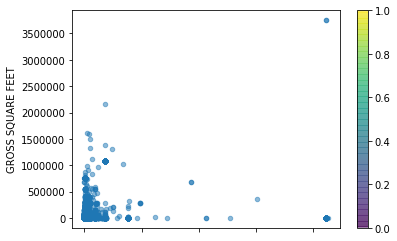

In [51]:
salesdf.plot(x='LAND SQUARE FEET',y='GROSS SQUARE FEET',kind='scatter',alpha=0.5,cmap='rainbow')

In [52]:
#No direct relationship trend is seen

In [53]:
L4 = salesdf['SALE PRICE']

In [54]:
#anova
model = ols('L4 ~ C(Q("TAX CLASS AT TIME OF SALE"))', data=salesdf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => SALE PRICE - TAX CLASS AT TIME OF SALE")
display(anova_table)


Anova => SALE PRICE - TAX CLASS AT TIME OF SALE


,sum_sq,df,F,PR(>F)
"C(Q(""TAX CLASS AT TIME OF SALE""))",2.601757e+17,3.0,343.975884,4.817534e-222
Residual,2.131573e+19,84544.0,NaN,NaN


In [55]:
# since p-value is less than 0.05 then we reject h0 and there is significant difference of means sales of each tax class

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
group1 group2   meandiff   p-adj     lower          upper     reject
--------------------------------------------------------------------
     1      2 1270338.0523 0.001    978146.3381  1562529.7664   True
     1      3 5744648.8657 0.879 -14652766.1188 26142063.8503  False
     1      4 6865068.7899 0.001   6312952.4161  7417185.1636   True
     2      3 4474310.8135   0.9 -15923232.7202 24871854.3472  False
     2      4 5594730.7376 0.001   5037885.4751  6151576.0001   True
     3      4 1120419.9241   0.9 -19282502.3838  21523342.232  False
--------------------------------------------------------------------


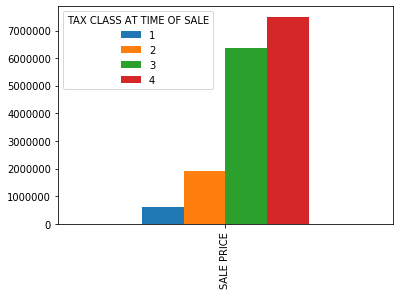

In [56]:
tukey = pairwise_tukeyhsd(endog=salesdf['SALE PRICE'],
                          groups=salesdf['TAX CLASS AT TIME OF SALE'],
                          alpha=0.05)

#display results
print(tukey)
salesdf.pivot_table(columns=['TAX CLASS AT TIME OF SALE'], values='SALE PRICE', aggfunc=np.mean).round(2).plot.bar()

In [57]:
# tukey shows tax class '1' '2' | '1' '4' | '2' '4'  have different mean sale price and this is also evident from bar graph